Here we are going to take a set of COGs we generated from the Introduction to COGs tutorial and place them on Google Cloud to be publicly ingestible. First, we will demonstrate how to upload sample COGs to a bucket in Google Cloud Storage and make them publicly readable. We can then stream the COG from its online location and read into QGIS Desktop or the cogeo.com/map tool.

## Uploading COGs to Google Cloud Storage

  ### Creating a Bucket

A bucket serves as a container to store your data. In our case, this is where we will store our collection of COGs. For the purpose of this demonstration, when creating the bucket we did not enforce public access prevention because we want our COGs accessible to the internet. We also set access control to be Uniform Bucket Access. Please select the best options for your use case.

### Making Objects Within Bucket Publicly Readable

Now we want to make our sample COGs readable to the public internet. To do so, we need go to Permissions, add allUsers as a new member, and set the role to be <b>Storage Object Viewer</b>

To learn more about bucket creation and access control specifications that best suits your particular use case, refer to https://cloud.google.com/storage/docs/how-to to learn more about working with Google Cloud Storage.

---

## Streaming Our COGs

Now that we have stored our COGs online in a newly created storage bucket, we can now start streaming these COGs from their online locations and take a look!

 ### Using cogeo.com/map

cogeo.com has a great mapping tool that you can use to display any COG that is stored online. This tool basically turns COGs into web tiles through the underlying web tiling service called tiles.rdnt.io. By entering the public url into the search bar, you can inspect your COG, zoom around, and share it with others.

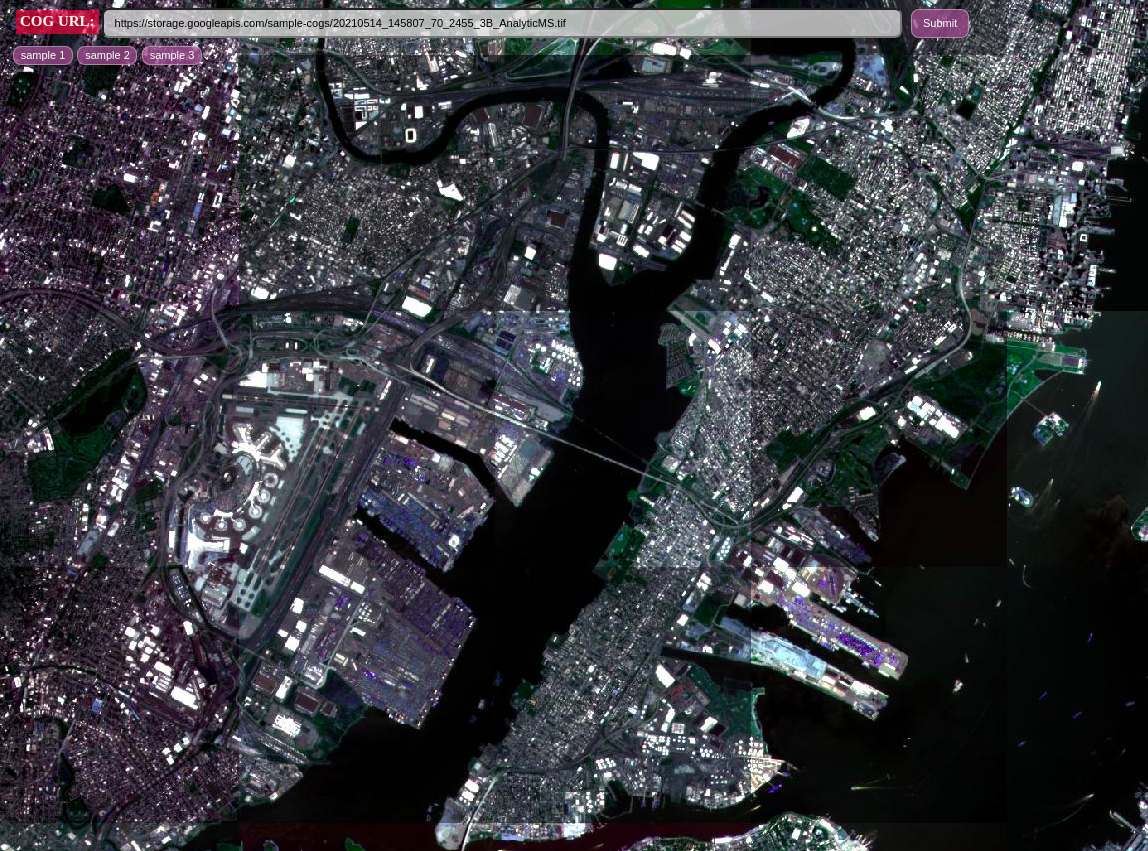

 ### Using QGIS Desktop

You can also take the public url and stream your COG directly in QGIS Desktop. To do this, first open the Data Source Manager by clicking on the icon on the top left of your screen. Select the Raster dialog from the list of options. Select 'Protocol: HTTP(S), cloud,etc' and set type to be HTTP/HTTPS/FTP. Paste the public url for the COG below.

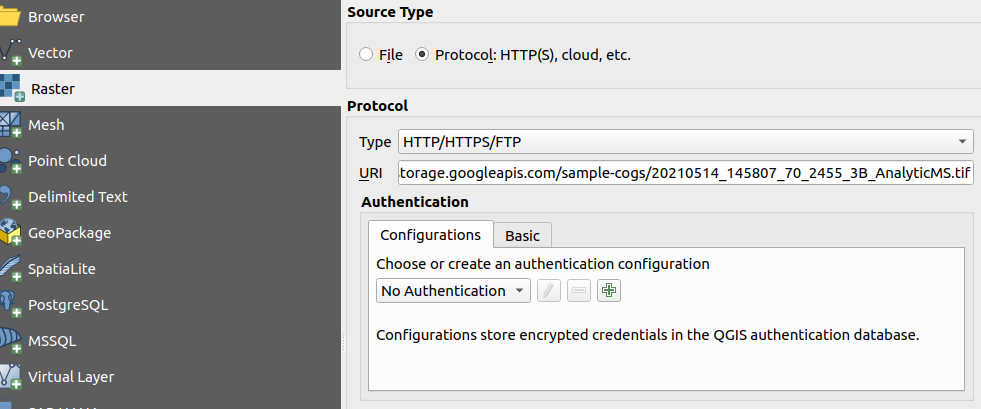

Click save and close the Data Manager to begin viewing your COG in QGIS.

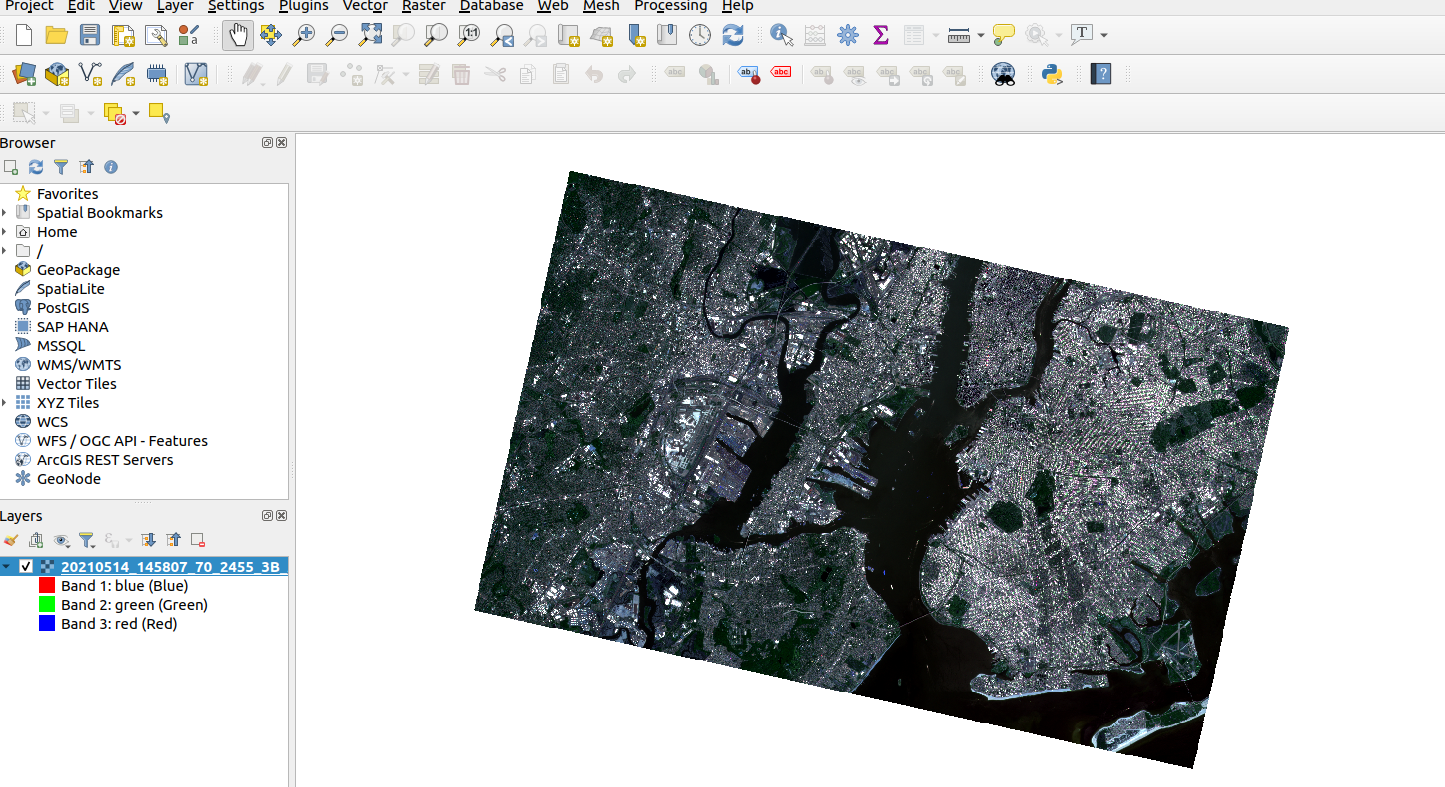

---

## Dynamic Tiling with TiTiler

TiTiler is dynamic tile server built on top of rio-tiler, the FastAPI web framework and Rasterio/GDAL. We will use TiTiler to serve up the tiles from our sample COG locally on our machine and explore some of the default COG endpoints of the application.

You can install and begin running the application locally by:

<b>pip install uvicorn titiler.application</b>

<b>uvicorn titiler.application.main:app</b>

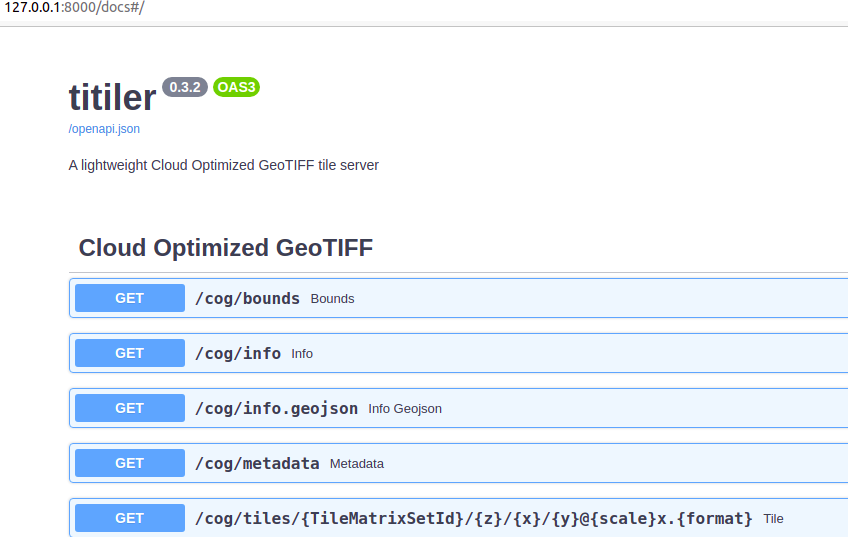

Now that we our application running locally on our machine, let's explore some of the default cog endpoints and take a look at the responses we get.

In [1]:
import requests
import json
from folium import Map, TileLayer
from io import BytesIO
import rasterio

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
titiler_endpoint = "http://127.0.0.1:8000"  
# Two sample COGs - one being a PSScene4Band analytic image and the other being a PSOrthoTile visual image
# from the Google Cloud storage bucket
analytic_cog_url = "https://storage.googleapis.com/sample-cogs/20210514_145807_70_2455_3B_AnalyticMS.tif"
visual_cog_url = "https://storage.googleapis.com/sample-cogs/cog/4478204_1857918_2021-05-14_2455_RGB_Visual.tif"

In [3]:
def submit_request(BASE_URL, endpoint, url):
    r = requests.get(
        f"{BASE_URL}/{endpoint}",
        params = {
            "url": url,
        }
    ).json()
    return r

---

### COG Validation Endpoint

We saw multiple possibilities of validating COGs in the previous tutorial. TiTiler itself also has a validation endpoint in the application where you can confirm if your GeoTIFF is a COG and get back some info.Let's make a GET request to the <b>/cog/validate</b> endpoint and check it out.

Here we get a similar breakdown of the COG information we found out using rio cogeo in the previous tutorial. We can verify that both of our GeoTIFFs are indeed COGs that have internal tiling and multiple overviews.

#### Analytic

In [4]:
analytic_cog_validation = submit_request(titiler_endpoint, "cog/validate", analytic_cog_url)
print(json.dumps(analytic_cog_validation, indent=4))

{
    "Path": "https://storage.googleapis.com/sample-cogs/20210514_145807_70_2455_3B_AnalyticMS.tif",
    "Driver": "GTiff",
    "COG": true,
    "Compression": "DEFLATE",
    "ColorSpace": null,
    "COG_errors": null,
    "COG_warnings": null,
    "Profile": {
        "Bands": 4,
        "Width": 13795,
        "Height": 9952,
        "Tiled": true,
        "Dtype": "uint16",
        "Interleave": "PIXEL",
        "AlphaBand": false,
        "InternalMask": false,
        "Nodata": 0.0,
        "ColorInterp": [
            "blue",
            "green",
            "red",
            "undefined"
        ],
        "ColorMap": false,
        "Scales": [
            1.0,
            1.0,
            1.0,
            1.0
        ],
        "Offsets": [
            0.0,
            0.0,
            0.0,
            0.0
        ]
    },
    "GEO": {
        "CRS": "EPSG:32618",
        "BoundingBox": [
            558549.0,
            4488015.0,
            599934.0,
            4517871.0


#### Visual

In [5]:
visual_cog_validation = submit_request(titiler_endpoint, "cog/validate", visual_cog_url)
print(json.dumps(visual_cog_validation, indent=4))

{
    "Path": "https://storage.googleapis.com/sample-cogs/cog/4478204_1857918_2021-05-14_2455_RGB_Visual.tif",
    "Driver": "GTiff",
    "COG": true,
    "Compression": "LZW",
    "ColorSpace": null,
    "COG_errors": null,
    "COG_warnings": null,
    "Profile": {
        "Bands": 4,
        "Width": 8000,
        "Height": 8000,
        "Tiled": true,
        "Dtype": "uint8",
        "Interleave": "PIXEL",
        "AlphaBand": true,
        "InternalMask": false,
        "Nodata": null,
        "ColorInterp": [
            "red",
            "green",
            "blue",
            "alpha"
        ],
        "ColorMap": false,
        "Scales": [
            1.0,
            1.0,
            1.0,
            1.0
        ],
        "Offsets": [
            0.0,
            0.0,
            0.0,
            0.0
        ]
    },
    "GEO": {
        "CRS": "EPSG:32618",
        "BoundingBox": [
            571500.0,
            4511500.0,
            596500.0,
            4536500.0
 

---

### COG Metadata Endpoint

Let's make a GET request to the <b>/cog/metadata</b> endpoint to gather some basic info and summary statistics of our COG. This includes its bounding box and some summary statistics for each band. If we look at the statistics for each band, we can see a list of histogram bins followed by a list of min and max values within each bin. We can also see what the percentage of valid pixels(pixels that have data) is.

#### Analytic

In [6]:
analytic_cog_metadata = submit_request(titiler_endpoint, "cog/metadata", analytic_cog_url)
print(json.dumps(analytic_cog_metadata, indent=4))

{
    "bounds": [
        -74.30860815002872,
        40.53685919989149,
        -73.81522948934723,
        40.80976203894409
    ],
    "band_metadata": [
        [
            "1",
            {}
        ],
        [
            "2",
            {}
        ],
        [
            "3",
            {}
        ],
        [
            "4",
            {}
        ]
    ],
    "band_descriptions": [
        [
            "1",
            "blue"
        ],
        [
            "2",
            "green"
        ],
        [
            "3",
            "red"
        ],
        [
            "4",
            "nir"
        ]
    ],
    "dtype": "uint16",
    "nodata_type": "Nodata",
    "colorinterp": [
        "blue",
        "green",
        "red",
        "undefined"
    ],
    "statistics": {
        "1": {
            "percentiles": [
                4360.0,
                13800.0
            ],
            "min": 3938.0,
            "max": 26652.0,
            "std": 2341.32055537477

#### Visual

In [7]:
visual_cog_metadata = submit_request(titiler_endpoint, "cog/metadata", visual_cog_url)
print(json.dumps(visual_cog_metadata, indent=4))

{
    "bounds": [
        -74.15301677654034,
        40.74879573187055,
        -73.85303951686923,
        40.97653527298751
    ],
    "band_metadata": [
        [
            "1",
            {}
        ],
        [
            "2",
            {}
        ],
        [
            "3",
            {}
        ],
        [
            "4",
            {}
        ]
    ],
    "band_descriptions": [
        [
            "1",
            ""
        ],
        [
            "2",
            ""
        ],
        [
            "3",
            ""
        ],
        [
            "4",
            ""
        ]
    ],
    "dtype": "uint8",
    "nodata_type": "Alpha",
    "colorinterp": [
        "red",
        "green",
        "blue",
        "alpha"
    ],
    "statistics": {
        "1": {
            "percentiles": [
                11.0,
                228.0
            ],
            "min": 1.0,
            "max": 255.0,
            "std": 56.33194131240483,
            "histogram": [


---

### GeoJson Info Endpoint

If we make a GET request to the <b>/cog/info.geojson</b> endpoint, we can also get back the GeoJson feature for the COG as well.

In [8]:
cog_geojson = submit_request(titiler_endpoint, "cog/info.geojson", analytic_cog_url)
print(json.dumps(cog_geojson, indent=4))

{
    "type": "Feature",
    "geometry": {
        "coordinates": [
            [
                [
                    -74.30860815002872,
                    40.80976203894409
                ],
                [
                    -74.30860815002872,
                    40.53685919989149
                ],
                [
                    -73.81522948934723,
                    40.53685919989149
                ],
                [
                    -73.81522948934723,
                    40.80976203894409
                ],
                [
                    -74.30860815002872,
                    40.80976203894409
                ]
            ]
        ],
        "type": "Polygon"
    },
    "properties": {
        "band_metadata": [
            [
                "1",
                {}
            ],
            [
                "2",
                {}
            ],
            [
                "3",
                {}
            ],
            [
                "4

In [9]:
cog_geojson = submit_request(titiler_endpoint, "cog/info.geojson", visual_cog_url)
print(json.dumps(cog_geojson, indent=4))

{
    "type": "Feature",
    "geometry": {
        "coordinates": [
            [
                [
                    -74.15301677654034,
                    40.97653527298751
                ],
                [
                    -74.15301677654034,
                    40.74879573187055
                ],
                [
                    -73.85303951686923,
                    40.74879573187055
                ],
                [
                    -73.85303951686923,
                    40.97653527298751
                ],
                [
                    -74.15301677654034,
                    40.97653527298751
                ]
            ]
        ],
        "type": "Polygon"
    },
    "properties": {
        "band_metadata": [
            [
                "1",
                {}
            ],
            [
                "2",
                {}
            ],
            [
                "3",
                {}
            ],
            [
                "4

---

### TileJson Endpoint

Now, let's make a GET request to the <b>/cog/[{TileMatrixSetId}]/tilejson.json</b> endpoint where the TileMatrixSetId refers to the public url of our COG. This endpoint will return a MapBox TileJson document, a json specification for talking about tilesets and optional metadata associated with them.

#### Analytic

In [10]:
tile_json_analytic = submit_request(titiler_endpoint, "cog/tilejson.json", analytic_cog_url)
print(json.dumps(tile_json_analytic, indent=4))

{
    "tilejson": "2.2.0",
    "name": "sample-cogs/20210514_145807_70_2455_3B_AnalyticMS.tif",
    "version": "1.0.0",
    "scheme": "xyz",
    "tiles": [
        "http://127.0.0.1:8000/cog/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fstorage.googleapis.com%2Fsample-cogs%2F20210514_145807_70_2455_3B_AnalyticMS.tif"
    ],
    "minzoom": 9,
    "maxzoom": 15,
    "bounds": [
        -74.30860815002872,
        40.53685919989149,
        -73.81522948934723,
        40.80976203894409
    ],
    "center": [
        -74.06191881968797,
        40.67331061941779,
        9
    ]
}


#### Visual

In [11]:
tile_json_visual = submit_request(titiler_endpoint, "cog/tilejson.json", visual_cog_url)
print(json.dumps(tile_json_visual, indent=4))

{
    "tilejson": "2.2.0",
    "name": "sample-cogs/cog/4478204_1857918_2021-05-14_2455_RGB_Visual.tif",
    "version": "1.0.0",
    "scheme": "xyz",
    "tiles": [
        "http://127.0.0.1:8000/cog/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fstorage.googleapis.com%2Fsample-cogs%2Fcog%2F4478204_1857918_2021-05-14_2455_RGB_Visual.tif"
    ],
    "minzoom": 10,
    "maxzoom": 15,
    "bounds": [
        -74.15301677654034,
        40.74879573187055,
        -73.85303951686923,
        40.97653527298751
    ],
    "center": [
        -74.00302814670479,
        40.86266550242903,
        10
    ]
}


---

### COG Viewer Endpoint

Let's go to the <b>/cog/viewer</b> endpoint to view our selected COG. Enter the url of the chosen COG. Once you hit apply, Titiler will recreate the tiles dynamically on the fly.

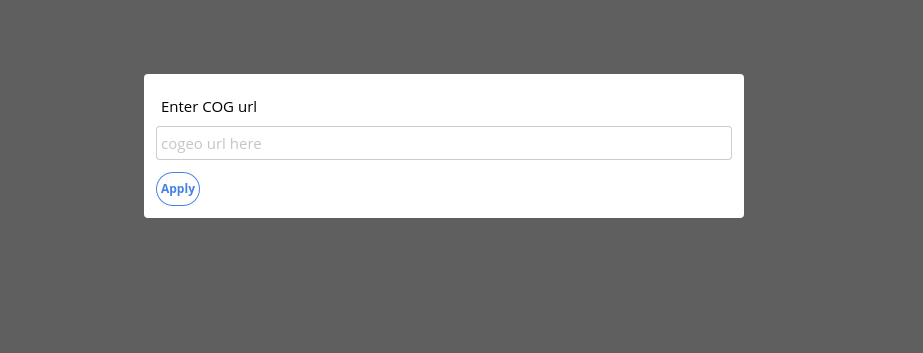

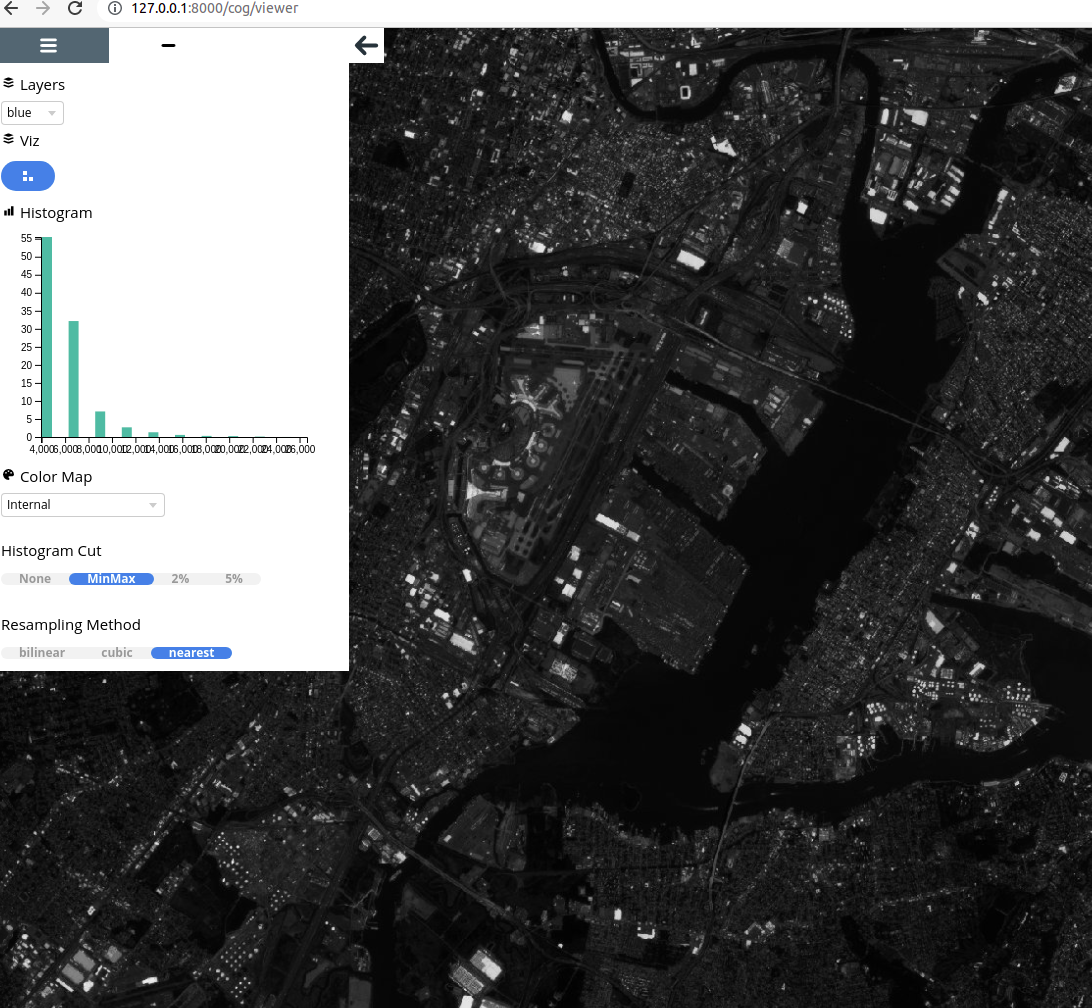

#### Layer Selection

Let's take a look at the left side-panel. The layers dropdown menu allows us to specify which band we want to look at.

#### Raster Data Histograms

The panel also provides a histogram to visualize the distribution of pixel values, where each bin represents the frequency of pixels that fall within the range of the bin.

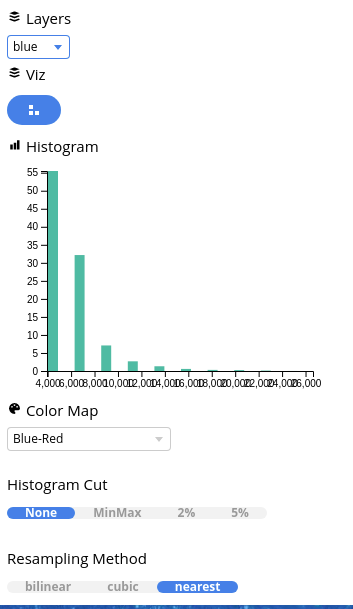

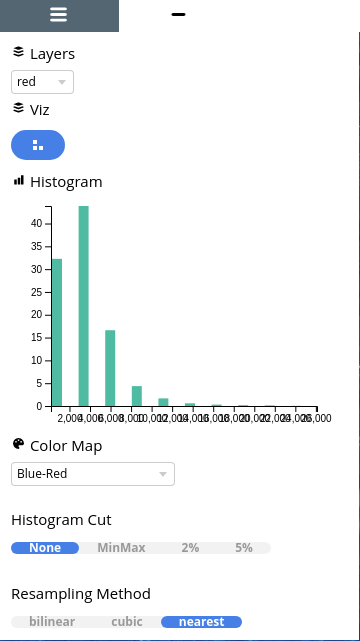

We can also visualize this raster histogram after we stream our COG into QGIS. To do this, right click on the layer name and select Properties from the context menu. From the Raster Layer Properties dialog, choose the histogram option. We can see that the output mirrors the distributions displayed from the /cog/viewer endpoint in TiTiler and the summary statistics obtained from our previous request to the /cog/metadata endpoint.

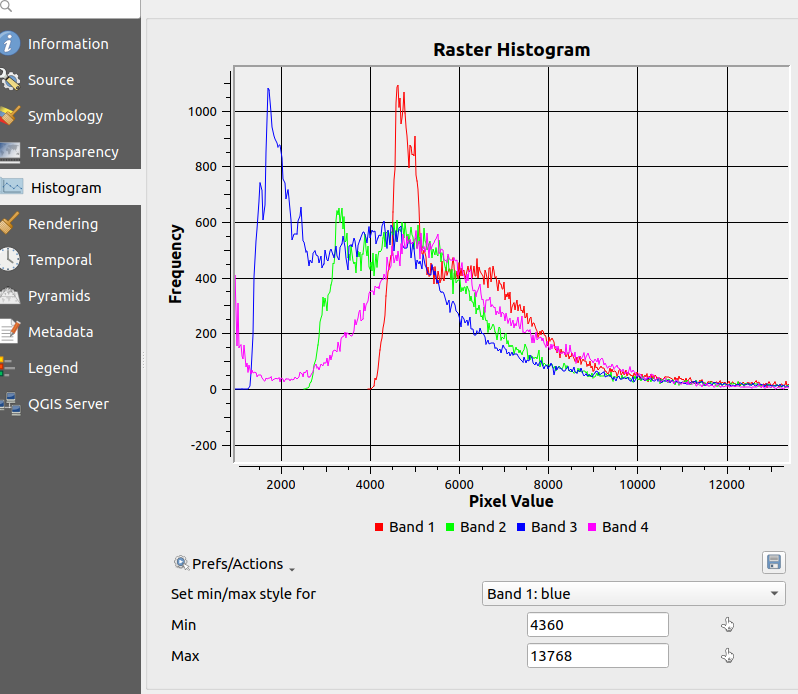

### Displaying Tiles Using Folium and Leaflet

We can also use the python library folium to visualize our COG in an interactive Leaflet map.

We can refer back to the tilejson document and extract the values from the bounding box to instantiate the Map object. We will use the url of the COG to create the TileLayer and add it to the map.

In [12]:
tileset = tile_json_analytic["tiles"][0]
tileset

'http://127.0.0.1:8000/cog/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fstorage.googleapis.com%2Fsample-cogs%2F20210514_145807_70_2455_3B_AnalyticMS.tif'

In [13]:
left, bottom, right, top = tile_json_analytic["bounds"][0], tile_json_analytic["bounds"][1], tile_json_analytic["bounds"][2], tile_json_analytic["bounds"][3]

In [14]:
m = Map(
    location=((bottom + top)/2, (left + right)/2),
    zoom_start=10,
    tiles="Stamen Terrain"
)
tile_layer = TileLayer(
    tiles= tileset,
    attr="Sample COG"
)

tile_layer.add_to(m)

In [15]:
m